In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

## Set up

In [3]:
import os
import tqdm
import joblib
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.multioutput import RegressorChain
from sklearn.base import BaseEstimator, clone
from sklearn.compose import ColumnTransformer
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, TargetEncoder

import catboost as cb
import lightgbm as lgbm
import xgboost as xgb

import tensorflow as tf
from tensorflow.compat.v1.losses import compute_weighted_loss

from utils import load_config
from src.helpers import (
    ContiguousGroupKFold, 
    ContiguousTimeSeriesSplit,
    custom_log_likelihood, 
    compute_per_station_metrics, 
    get_station_stats, 
    standardize_values, 
    standardize_prediction_intervals, 
    compute_per_station_metrics, 
    summarize_metrics,
    compute_non_negative_log_likelihood,
    GroupMinMaxScaler,
    GroupStandardScaler
)

2025-04-10 22:23:11.422475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 22:23:11.470158: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-10 22:23:11.485507: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 22:23:11.565836: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 22:23:13.066672: W tensorflow/compiler/tf2

## Constants

In [66]:
config = load_config()

In [67]:
DATA_DIR = config['final_data']
TRAIN = os.path.join(DATA_DIR, 'train.csv')
TEST = os.path.join(DATA_DIR, 'eval.csv')

## Modelling

- Direct Regressor: Predicts outputs and prediction interval directly
  - GBT with quantile loss
  - deep learning with quantile loss
- Ensemble Regressor: Uses a monte-carlo simulation to generate prediction interval
  - GBT with ensemble
  - deep learning with ensemble
- CV ensemble modelling - fold cross validation

In [68]:
CV_SPLIT = 5

#### Load data

In [69]:
df = pd.read_csv(TRAIN)
df_test = pd.read_csv(TEST)

/tmp/ipykernel_478762/1427115751.py:1: DtypeWarning: Columns (19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(TRAIN)


In [70]:
CATEGORICAL = [
    'river', 'hydro_region', 'hydro_sector', 'hydro_sub_sector', 'hydro_zone', 'region_sector', 
    'region_sub_sector', 'region_zone', 'sector_sub_sector', 'sector_zone', 'sub_sector_zone', 'location', 'month', 'week', 'season'
]

In [71]:
for col in CATEGORICAL:
    df[col] = df[col].astype('str')
    df_test[col] = df_test[col].astype('str')

In [72]:
LOCATION = ['longitude', 'latitude']

NUM_STATION = ['altitude', 'catchment']
NUM_SOIL = ['bdod', 'cfvo', 'clay', 'sand']
NUM_METEO = ['tp', 't2m', 'swvl1', 'evap']
COLS_TO_DROP = ['ObsDate', 'year', 'catchment', 'station_code']
TARGET_COLS = ['water_flow_week_1', 'water_flow_week_2', 'water_flow_week_3', 'water_flow_week_4']
LAG_COLS = ['water_flow_lag_1w', 'water_flow_lag_2w', 'water_flow_rolling_mean_4w']
CONTINUOUS_COLS = list(df.select_dtypes(['float', 'int']).drop(columns = TARGET_COLS + COLS_TO_DROP + LAG_COLS, errors = 'ignore').columns)

### Train Test Split
- Based on previous analysis, the dataset exhibits annual seasonality but no significant long-term trend.
- Therefore, it is acceptable to use chronological or block-wise splits without always reserving the most recent data for validation.
- This approach is appropriate for seasonally-repeating time series, where the assumption of trend-driven data drift does not hold.
- In such cases, the model's ability to generalize across seasonal cycles is more important than strict recency.

In [73]:
cgkf = ContiguousGroupKFold(5)
for idx, (train_ids, val_ids) in enumerate(cgkf.split(df, groups = df.year)):
    print(f'Years in fold {idx + 1}')
    print('Train:', *df.iloc[train_ids].year.unique())
    print('Validation:', *df.iloc[val_ids].year.unique())
    print('-------------------------------------------------------------------------')

Years in fold 1
Train: 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
Validation: 1990 1991 1992
-------------------------------------------------------------------------
Years in fold 2
Train: 1990 1991 1992 1996 1997 1998 1999 2000 2001 2002 2003 2004
Validation: 1993 1994 1995
-------------------------------------------------------------------------
Years in fold 3
Train: 1990 1991 1992 1993 1994 1995 1999 2000 2001 2002 2003 2004
Validation: 1996 1997 1998
-------------------------------------------------------------------------
Years in fold 4
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 2002 2003 2004
Validation: 1999 2000 2001
-------------------------------------------------------------------------
Years in fold 5
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
Validation: 2002 2003 2004
-------------------------------------------------------------------------


In [74]:
cgkf = ContiguousTimeSeriesSplit(5, 0.6)#, test_size = 2)
for idx, (train_ids, val_ids) in enumerate(cgkf.split(df, groups = df.year)):
    print(f'Years in fold {idx + 1}')
    print('Train:', *df.iloc[train_ids].year.unique())
    print('Validation:', *df.iloc[val_ids].year.unique())
    print('-------------------------------------------------------------------------')

Years in fold 1
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998
Validation: 1999 2000 2001 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 2
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
Validation: 2000 2001 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 3
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
Validation: 2001 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 4
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
Validation: 2002 2003 2004
-------------------------------------------------------------------------
Years in fold 5
Train: 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
Validation: 2003 2004
-------------------------------------------------------------------------


### Models

In [75]:
def create_deep_learning_model(cat_input_shapes, cont_input_shape, output_shape, embedding_dim=8, gru_n_layers = 2, gru_units=64, dropout = 0.2):
    """
    cat_input_shapes: list of vocab sizes for each categorical input
    cont_input_shape: number of continuous features (not a sequence)
    output_steps: number of sequential outputs to generate
    """
    # Inputs
    cont_input = tf.keras.layers.Input(shape=(cont_input_shape,), name='continuous_input')
    
    cat_inputs = []
    cat_embeddings = []

    for i, vocab_size in enumerate(cat_input_shapes):
        input_i = tf.keras.layers.Input(shape=(1,), name=f'cat_input_{i}')
        embedding_i = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, name=f'embedding_{i}')(input_i)
        embedding_i = tf.keras.layers.Reshape((embedding_dim,))(embedding_i)
        cat_inputs.append(input_i)
        cat_embeddings.append(embedding_i)

    # Concatenate all features (static input)
    x = tf.keras.layers.Concatenate()(cat_embeddings + [cont_input])  # shape: (batch, features)

    # Project to GRU dimension
    x = tf.keras.layers.Dense(gru_units, use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(gru_units, activation='relu')(x)

    # Repeat vector to create initial sequence input for GRU
    x = tf.keras.layers.RepeatVector(output_shape)(x)  # shape: (batch, output_steps, gru_units)

    # GRU layers to model temporal dependency in output
    x = tf.keras.layers.GRU(gru_units, return_sequences=True)(x)
    x = tf.keras.layers.GRU(gru_units, return_sequences=True)(x)

    # Final output: 1 value per timestep
    output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation = 'softplus'))(x)

    model = tf.keras.Model(inputs=cat_inputs + [cont_input], outputs=output)
    return model


In [76]:
import numpy as np
import os
import json
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, RegressorMixin, clone

class ChainedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator, n_targets = None):
        self.base_estimator = base_estimator
        self.models_ = []
        self.n_targets = n_targets

    def fit(self, X, y, eval_set=None, **fit_params):
        # X = np.array(X)
        # Y = np.array(y)
        self.models_ = []

        self.n_targets = y.shape[1]

        X_val, Y_val = None, None
        if eval_set:
            X_val, Y_val = eval_set[0]
            # X_val = np.array(X_val)
            # Y_val = np.array(Y_val)

        X_train_chain = X.copy()
        X_val_chain = X_val.copy() if eval_set else None

        for i in range(self.n_targets):
            model = clone(self.base_estimator)
            y_train_i = y.iloc[:, i]

            # Resolve fit parameters (per target if needed)
            local_fit_params = {}
            for k, v in fit_params.items():
                if isinstance(v, (list, tuple)) and len(v) == self.n_targets:
                    local_fit_params[k] = v[i]
                else:
                    local_fit_params[k] = v

            if eval_set:
                y_val_i = Y_val.iloc[:, i]
                model.fit(
                    X_train_chain, y_train_i,
                    eval_set=[(X_val_chain, y_val_i)],
                    **local_fit_params
                )
            else:
                model.fit(X_train_chain, y_train_i, **local_fit_params)

            self.models_.append(model)

            y_pred_train = model.predict(X_train_chain).reshape(-1, 1)
            X_train_chain[f'pred_{i}'] = y_pred_train #np.hstack([X_train_chain, y_pred_train])

            if eval_set:
                y_pred_val = model.predict(X_val_chain).reshape(-1, 1)
                X_val_chain = np.hstack([X_val_chain, y_pred_val])

        return self

    def predict(self, X):
        X = np.array(X)
        X_chain = X.copy()
        preds = []

        for model in self.models_:
            y_pred = model.predict(X_chain).reshape(-1, 1)
            preds.append(y_pred)
            X_chain = np.hstack([X_chain, y_pred])

        return np.hstack(preds)

    def save_model(self, path):
        """Save the chained model to disk."""
        os.makedirs(path, exist_ok=True)

        meta = {
            'n_targets': self.n_targets,
            'model_paths': []
        }

        for idx, model in enumerate(self.models_):
            model_path = os.path.join(path, f"catboost_target_{idx}.cbm")
            model.save_model(model_path)
            meta['model_paths'].append(f"catboost_target_{idx}.cbm")

        with open(os.path.join(path, "metadata.json"), "w") as f:
            json.dump(meta, f)

    @classmethod
    def load_model(cls, path, base_estimator):
        """Load the chained model from disk."""
        with open(os.path.join(path, "metadata.json")) as f:
            meta = json.load(f)

        model = cls(base_estimator=base_estimator, n_targets=meta['n_targets'])
        model.models_ = []

        for model_file in meta['model_paths']:
            cbm = clone(base_estimator)
            cbm.load_model(os.path.join(path, model_file))
            model.models_.append(cbm)

        return model


In [77]:
def create_catboost_model(*args, chain_cv = None, **kwargs):
    base_model = cb.CatBoostRegressor(*args, **kwargs)
    model = RegressorChain(base_model, order = None, cv = chain_cv, random_state=42, verbose=False)
    return model

In [78]:
def create_gbt_model(*args, model_type = 'catboost',  chain_cv = None, **kwargs):
    if model_type == 'catboost':
        base_model = cb.CatBoostRegressor(*args, **kwargs)
    elif model_type == 'lightgbm':
        base_model = lgbm.LGBMRegressor(*args, **kwargs)
    elif model_type == 'xgboost':
        base_model = xgb.XGBRegressor(*args, **kwargs)
    else:
        raise ValueError('Unsupported model type')
    # model = RegressorChain(base_model, order = None, cv = chain_cv, random_state=42, verbose=False)
    model = ChainedRegressor(base_model)
    return model
        

In [79]:
class QuantileLoss(tf.keras.losses.Loss):
    def __init__(self, alpha, *args, name="quantile_loss", **kwargs):
        super().__init__(*args, name=name, **kwargs)
        self.alpha = alpha

    def call(self, y_true, y_pred, sample_weight=None):
        e = y_true - y_pred
        loss = tf.maximum(self.alpha * e, (self.alpha - 1) * e)
        return compute_weighted_loss(loss, sample_weight, reduction=self.reduction)

In [80]:
class MultiMAEMetric(cb.MultiTargetCustomMetric):
    # def __init__(self):
        # super().__init__()
        
    def get_final_error(self, error, weight):
        """
        Compute the final MAE error after evaluation.
        
        Parameters:
        - error: The accumulated error (sum of absolute errors).
        - weight: The accumulated weight (sum of weights).
        
        Returns:
        - The final MAE value.
        """
        return error / (weight + 1e-38)  # Adding small epsilon to avoid division by zero

    def is_max_optimal(self):
        """
        Return whether a higher value of the metric is considered better.
        Since we are minimizing MAE, return False.
        """
        return False

    def evaluate(self, approxes, target, weight):
        """
        Calculate the weighted MAE for multi-output (multi-target) regression.
        
        Parameters:
        - approxes: List of predicted values (approximations) for each target.
        - target: List of true values for each target.
        - weight: Weight of each data point.
        
        Returns:
        - error_sum: The total weighted error across all samples and targets.
        - weight_sum: The total weight across all samples.
        """
        assert len(target) == len(approxes)  # Ensure the lengths match
        assert len(target[0]) == len(approxes[0])  # Ensure the number of targets match

        error_sum = 0.0
        weight_sum = 0.0

        # Loop through each target dimension (e.g., 1st target, 2nd target)
        for i in range(len(approxes[0])):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            
            # Calculate the absolute error for each sample
            for d in range(len(approxes)):  # Loop through all the data samples
                error_sum += w * np.abs(approxes[d][i] - target[d][i])
                
        return error_sum, weight_sum


In [81]:
class MultiLowerQuantileLoss(cb.MultiTargetCustomObjective):
    # def __init__(self, quantile=0.5, **kwargs):
    #     """
    #     Initialize the multi-quantile loss objective.
        
    #     Parameters:
    #     quantile: The quantile to optimize for (e.g., 0.05 for 5th percentile, 0.95 for 95th percentile).
    #     """
    #     self.quantile = quantile
    #     # super().__init__(**kwargs)

    def calc_ders_multi(self, approxes, target, weight):
        """
        Calculate the gradient (derivative) and Hessian (second derivative) for multi-target quantile loss.

        Parameters:
        approx: List of predicted values for each target.
        target: List of true values for each target.
        weight: Weight of the current data point.
        
        Returns:
        tuple: (der1, der2) where:
            - der1: List of gradients (first derivatives) for each target.
            - der2: List of Hessians (second derivatives) for each target.
        """
        quantile = 0.05
        assert len(target) == len(approxes)
        w = weight if weight is not None else 1.0

        der1 = [w * quantile if (target[i] - approxes[i]) >= 0 else (quantile - 1) * w for i in range(len(approxes))]
        der2 = [[0] for _ in range(len(approxes))]

        return (der1, der2)


In [82]:
class MultiUpperQuantileLoss(cb.MultiTargetCustomObjective):
    # def __init__(self, quantile=0.5, **kwargs):
    #     """
    #     Initialize the multi-quantile loss objective.
        
    #     Parameters:
    #     quantile: The quantile to optimize for (e.g., 0.05 for 5th percentile, 0.95 for 95th percentile).
    #     """
    #     self.quantile = quantile
    #     # super().__init__(**kwargs)

    def calc_ders_multi(self, approxes, target, weight):
        """
        Calculate the gradient (derivative) and Hessian (second derivative) for multi-target quantile loss.

        Parameters:
        approx: List of predicted values for each target.
        target: List of true values for each target.
        weight: Weight of the current data point.
        
        Returns:
        tuple: (der1, der2) where:
            - der1: List of gradients (first derivatives) for each target.
            - der2: List of Hessians (second derivatives) for each target.
        """
        assert len(target) == len(approxes)
        w = weight if weight is not None else 1.0

        der1 = [w * self.quantile if (target[i] - approxes[i]) >= 0 else (self.quantile - 1) * w for i in range(len(approxes))]
        der2 = [[0] for _ in range(len(approxes))]

        return (der1, der2)


In [83]:
class MultiMAELoss(cb.MultiTargetCustomObjective):
    def calc_ders_multi(self, approxes, target, weight):
        """
        Calculate the gradient (derivative) and Hessian (second derivative) for multi-target MAE loss.

        Parameters:
        approxes: List of predicted values for each target.
        target: List of true values for each target.
        weight: Weight of the current data point.
        
        Returns:
        tuple: (der1, der2) where:
            - der1: List of gradients (first derivatives) for each target.
            - der2: List of Hessians (second derivatives) for each target.
        """
        # Assert that the length of target and approxes are the same
        assert len(target) == len(approxes)

        # Apply weight if provided, else default to 1.0
        w = weight if weight is not None else 1.0

        # Calculate gradients (der1) and Hessians (der2)
        der1 = [w * np.sign(target[i] - approxes[i]) for i in range(len(target))]
        der2 = [[0] for i in range(len(approxes))]       
        return (der1, der2)


In [84]:
class MultiHuberLoss(cb.MultiTargetCustomObjective):
    # def __init__(self, delta=1.0, **kwargs):
    #     # super().__init__(**kwargs)
    #     self.delta = delta
    delta = 1

    def calc_ders_multi(self, approxes, target, weight):
        w = weight if weight is not None else 1.0

        # Compute errors
        errors = [target[i] - approxes[i] for i in range(len(approxes))]
        abs_errors = [abs(e) for e in errors]

        # Compute gradient and Hessian
        der1 = [
            errors[i] * w if abs_errors[i] <= self.delta
            else (self.delta * np.sign(errors[i])) * w
            for i in range(len(approxes))
        ]
        der2 = [
            [-1.0 * w] if abs_errors[i] <= self.delta else [0.00000000001]
            for i in range(len(approxes))
        ]

        return (der1, der2)


In [85]:
class BaseRegressor(ABC):
    def __init__(
        self, 
        model_fn = None, 
        model_params = None, 
        preprocessor = None, 
        cv = 5, 
        cv_group = 'year', 
        alphas = [0.05, 0.95], 
        method = 'indirect',
        n_models = 5,
        cat_features = None,
        exclude_cols = None,
        random_state = 42,
        bootstrap = True,
        delta = 0.01,
        patience = 5,
        split_type = 'time_series'
    ):
        self.model_fn = model_fn
        self.model_params = model_params
        self.preprocessor = preprocessor
        self.cv = cv
        self.cv_group = cv_group
        self.alphas = alphas
        self.method = method
        self.n_models = n_models
        self.cat_features = cat_features
        self.exclude_cols = exclude_cols
        self.random_state = random_state
        self.bootstrap = bootstrap
        self.delta = delta
        self.patience = patience
        self.split_type = split_type
        # if self.model_params is not None:
        #     self.lr = self.model_params.pop('lr') if 'lr' in self.model_params.keys() else 0.01

        self.preprocessors = {}
        self.models = {}
        self.history = {}

    @abstractmethod
    def fit(self, X, y):           
        raise NotImplementedError

    @abstractmethod
    def predict(self, X):
        raise NotImplementedError

    @abstractmethod
    def save_model(self, save_path):
        raise NotImplementedError

    @abstractmethod
    def load_model(self, load_path):
        raise NotImplementedError

    @abstractmethod
    def prep_data_for_model(self, X):
        raise NotImplementedError

    def get_data(self, X, y, train_ids, val_ids):
        X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
        X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]
        return X_train, X_val, y_train, y_val

    def cv_split(self, X, group):
        if self.split_type == 'time_series':
            cvf = ContiguousTimeSeriesSplit(self.cv, 0.6)
        elif self.split_type == 'group_kfold':
            cvf = ContiguousGroupKFold(self.cv)
        else:
            raise ValueError('`split_type` must be one of `time_series` or `group_kfold`')
        return cvf.split(X, groups = group)
        

In [86]:
class DeepEnsembleRegressor(BaseRegressor):
    def __init__(self, *args, early_stopping = 3, save_best_weight = True, **kwargs):
        super().__init__(*args, **kwargs)
        self.early_stopping = early_stopping
        self.save_best_weight = save_best_weight

    def fit(self, X, y, batch_size = 32, epochs = 100):
        # split the data into folds
        splits = self.cv_split(X, X[self.cv_group])

        # loop through each fold
        for idx, (train_ids, val_ids) in enumerate(splits):
            # get fold data
            X_tr, X_v, y_train, y_val = self.get_data(X, y, train_ids, val_ids)
            
            # preprocess data
            preprocessor = clone(self.preprocessor)
            X_train = preprocessor.fit_transform(X_tr)
            X_val = preprocessor.transform(X_v)

            X_train = self.prep_data_for_model(X_train)
            X_val = self.prep_data_for_model(X_val)

            # save preprocessor
            self.preprocessors[f'fold_{idx}'] = preprocessor

            # get the model type to build, direct or indirect
            if self.method == 'direct':
                self.n_models = 3
                losses = [QuantileLoss(self.alphas[0]), tf.keras.losses.Huber(), QuantileLoss(self.alphas[-1])]
                for i in range(self.n_models):
                    # create model
                    model = self.model_fn(self.model_params)
                    # create callbacks
                    if self.early_stopping:
                        callbacks = [tf.keras.callbacks.EarlyStopping(monitor_loss = 'val_loss', patience = self.early_stopping, restore_best_weights = self.use_best_weight)]
                    else:
                        callbacks = None
                    # compile model
                    model.compile(loss = losses[i], optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr), metrics = ['mae', 'mse', non_negative_log_loss])
                    self.history[f'fold_{idx}_model_{i}'] = model.fit(
                        X_train, y_train, 
                        batch_size = batch_size, 
                        epochs = epochs, 
                        validation_data = [X_val, y_val],
                        callbacks = callbacks
                    )
                    # store model
                    self.models[f'fold_idx_model_{i}'] = model

            elif self.method == 'indirect':
                for i in range(self.n_models):
                    # create model
                    model = self.model_fn(self.model_params)
                    # create callbacks
                    if self.early_stopping:
                        callbacks = [tf.keras.callbacks.EarlyStopping(monitor_loss = 'val_loss', patience = self.early_stopping, restore_best_weights = self.use_best_weight)]
                    else:
                        callbacks = None
                    # compile model
                    model.compile(loss = smooth_loss(), optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr), metrics = 'mae')
                    self.history[f'fold_{idx}_model_{i}'] = model.fit(
                        X_train, y_train, 
                        batch_size = batch_size, 
                        epochs = epochs, 
                        validation_data = [X_val, y_val],
                        callbacks = callbacks
                    )
                    # store model
                    self.models[f'fold_idx_model_{i}'] = model

    def predict(self, X):
        results = {}
        for fold in self.cv:
            X_ = self.preprocessor[f'fold_{fold}'].fit_transform(X)
            X_ = self.prep_data_for_model(X_)
            for i in range(self.n_models):
                model = self.models[f'fold_{fold}_model_{i}']
                pred = model.predict(X_)
                pred = pred.squeeze(axis = -1)
                results[f'fold_{fold}_model_{i}'] = pred
                
        # aggregate by method.
        if self.method == 'indirect':
            # stack and aggregate by 
            results_ = np.stack(results.values(), axis = 1)
            mean_result = results_.mean(axis = 1)
            q_1 = np.quantile(results_, q = self.alphas[0], axis = 1)
            q_3 = np.quantile(results_,q = self.alphas[1], axis = 1)
            return {'pred' : mean_result, 'lower_quantile' : q_1, 'upper_quantile' : q3}
        elif self.method == 'direct':
            results_ = np.stack(results.values(), axis = 1)
            results_ = results_.reshape(X.shape[0], self.cv, 3, -1)
            results_ = results_.mean(axis = 1)
            out = {'pred': results_[:, 1, :], 'lower_quantile': results_[:, 0, :], 'upper_quantile': results[:, 2, :]}
            return out, results

    def save_model(self, save_path):
        os.makedirs(save_path, exist_ok=True)

        # save metadata
        metadata = {
            'method': self.method,
            'n_models': self.n_models,
            'alphas': self.alphas,
            'cv': list(self.preprocessors.keys())
        }
        with open(os.path.join(save_path, 'metadata.json'), 'w') as f:
            json.dump(metadata, f)
    
        # save each model
        for name, model in self.models.items():
            model_path = os.path.join(save_path, name)
            model.save(model_path)
    
        # save each preprocessor
        for name, preprocessor in self.preprocessors.items():
            joblib.dump(preprocessor, os.path.join(save_path, f'{name}_preprocessor.pkl'))

    def load_model(self, load_path):
         # Load metadata
        with open(os.path.join(load_path, 'metadata.json'), 'r') as f:
            metadata = json.load(f)
    
        self.method = metadata['method']
        self.n_models = metadata['n_models']
        self.alphas = metadata['alphas']
        self.preprocessors = {}
        self.models = {}
    
        # Load models
        for fold in metadata['cv']:
            for i in range(self.n_models):
                model_name = f'{fold}_model_{i}'
                model_path = os.path.join(load_path, model_name)
                self.models[model_name] = tf.keras.models.load_model(model_path)
    
            # Load preprocessor
            preproc_path = os.path.join(load_path, f'{fold}_preprocessor.pkl')
            self.preprocessors[fold] = joblib.load(preproc_path)
        
    def prep_data_for_model(self, X):
        # for deep learning convert categorical and continuous into a list of inputs
        X = X.copy()
        if self.exclude_cols is not None:
            X = X.drop(columns = self.exclude_cols, errors = 'ignore')
        data = []
        for col in self.cat_features:
            data.append(X[col])
        data.append(X.drop(columns = self.cat_features, errors = 'ignore'))
        return data


In [87]:
class GBTEnsembleRegressor(BaseRegressor):
    def __init__(self, *args, lr = None, model_type = 'catboost', **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = lr
        if self.lr is not None:
            if self.method == 'direct':
                assert len(self.lr) == 3, '`len(lr)` must be 3 if method = direct'
            elif self.method == 'indirect':
                assert len(self.lr) == self.n_models, '`len(lr)` must be same as n_models'
        self.model_type = model_type
        self.results = {}
        self.feature_names_ = None

    def fit(self, X, y, batch_size = 32, epochs = 100):
        # split the data into folds
        splits = self.cv_split(X, X[self.cv_group])

        # loop through each fold
        for idx, (train_ids, val_ids) in enumerate(splits):
            print(f'---------------------FOLD {idx}-------------------------')
            # get fold data
            X_train, X_val, y_train, y_val = self.get_data(X, y, train_ids, val_ids)

            # get station codes before preprocessing the data
            station_codes = X_val.station_code.values.tolist()
            
            # preprocess data
            if self.preprocessor is not None:                
                preprocessor = clone(self.preprocessor)
                X_train = preprocessor.fit_transform(X_train)
                X_val = preprocessor.transform(X_val)
    
                cols_ = preprocessor.get_feature_names_out()
                cols = [col.split('__')[-1] for col in cols_]
    
                X_train = pd.DataFrame(X_train, columns = cols, index = y_train.index)
                X_val = pd.DataFrame(X_val, columns = cols, index = y_val.index)

                # save preprocessor
                self.preprocessors[f'fold_{idx}'] = preprocessor

                # y_train = np.log1p(y_train)
                # y_val = np.log1p(y_val)

            X_train = self.prep_data_for_model(X_train)
            X_val = self.prep_data_for_model(X_val)

            self.feature_names_ = list(X_train.columns)

            # get the type of model to build, direct or indirect
            if self.method == 'direct':
                self.n_models = 3
                losses = [f'Quantile:alpha={self.alphas[0]}', 'LogCosh', f'Quantile:alpha={self.alphas[1]}']
                od_wait = [1, self.patience, 1]
                y_out = []
                for i in range(self.n_models):
                    print(f'Training model fold_{idx}_model_{i}')
                    # create model
                    model = self.build_model(self.model_type, loss_function = losses[i], eval_metric = 'MAE', lr = self.lr[i], od_wait = od_wait[i], random_state = self.random_state)  # use quantile loss
                    # fit model
                    model.fit(X_train, y_train, eval_set = [(X_val, y_val)])
                    # store model
                    self.models[f'fold_{idx}_model_{i}'] = model
                    print('----------------------------------------------------')
                    # store X_val predictions for evaluation
                    pred = model.predict(X_val)
                    # pred = np.expm1(pred)
                    y_out.append(np.clip(pred, 0, np.inf))
                y_pred = y_out[1].reshape(-1)
                y_lower = y_out[0].reshape(-1)
                y_upper = y_out[2].reshape(-1)

                y_out = np.sort(np.array([y_lower, y_pred, y_upper]), axis = 0)
                y_pred = y_out[1]
                y_lower = y_out[0] - self.delta
                y_upper = y_out[2] + self.delta
       
            elif self.method == 'indirect':
                y_out = []
                for i in range(self.n_models):
                    print(f'Training model fold_{idx}_model_{i}')
                    # create model
                    quantiles = np.linspace(self.alphas[0], self.alphas[1], self.n_models)
                    losses = [f'Quantile:alpha={q}' for q in quantiles]
                    od_wait = (np.exp(-np.abs(np.arange(self.n_models) - (self.n_models / 2))) * self.patience).astype(int)
                    model = self.build_model(self.model_type, loss_function = losses[i], eval_metric = 'MAE', od_wait = od_wait[i], random_state = i + idx*100)
                    # fit model
                    X_, y_ = self._resample(X_train, y_train, random_state = i + idx)
                    model.fit(X_, y_, eval_set = [(X_val, y_val)])
                    # store model
                    self.models[f'fold_{idx}_model_{i}'] = model
                    print('----------------------------------------------------')
                    pred = model.predict(X_val)
                    # pred = np.expm1(pred)
                    y_out.append(np.clip(pred, 0, np.inf))
                y_out = np.stack(y_out, axis = 1)
                y_pred = np.mean(y_out, axis = 1).reshape(-1)
                y_lower = np.quantile(y_out, 0, axis = 1).reshape(-1) - self.delta
                y_upper = np.quantile(y_out, 1, axis = 1).reshape(-1) + self.delta
                
            # compute per fold evaluation on nll
            # compute oof results
            y_true = y_val.values.reshape(-1)
            y_quantiles = np.array(list(zip(y_lower, y_upper)))
            station_codes = np.repeat(station_codes, y_val.shape[1])
            station_stats = get_station_stats(y_true, station_codes)
            print(len(station_codes), y_true.shape, y_pred.shape, station_stats.shape, y_quantiles.shape) 
            nll = compute_non_negative_log_likelihood(
                pd.Series(y_true),
                y_pred, 
                y_quantiles,
                station_codes,
                station_stats,
                alpha = 0.1
            )
            self.results[f'fold_{idx}'] = nll
            print('-------------------------------------------------')
            print(f'Fold {idx} NLL:', nll)

    def predict(self, X):
        results = {}
        for idx in range(self.cv):
            preprocessor = self.preprocessors[f'fold_{idx}']
            X_ = preprocessor.transform(X)
            cols_ = preprocessor.get_feature_names_out()
            cols = [col.split('__')[-1] for col in cols_]
            X_ = pd.DataFrame(X_, columns = cols)
            X_ = self.prep_data_for_model(X_)
            for i in range(self.n_models):
                model = self.models[f'fold_{idx}_model_{i}']
                pred = model.predict(X_)
                # pred = np.expm1(pred)
                results[f'fold_{idx}_model_{i}'] = pred
                
        # aggregate by method.
        results_ = np.stack(list(results.values()), axis = 1)
        if self.method == 'indirect':
            mean_result = results_.mean(axis = 1)
            q_1 = np.quantile(results_, q = self.alphas[0], axis = 1)
            q_3 = np.quantile(results_, q = self.alphas[1], axis = 1)
            out = {'pred' : mean_result, 'inf' : q_1, 'sup' : q_3}
        elif self.method == 'direct':
            results_ = results_.reshape(X.shape[0], self.cv, 3, -1)
            results_ = results_.mean(axis = 1)
            out = {'pred': results_[:, 1, :], 'inf': results_[:, 0, :], 'sup': results_[:, 2, :]}
        return out, results_

    def save_model(self, save_path):
        os.makedirs(save_path, exist_ok=True)

        # save metadata
        metadata = {
            'method': self.method,
            'n_models': self.n_models,
            'alphas': self.alphas,
            'cv': list(self.preprocessors.keys()),
            'cat_features': self.cat_features,
            'exclude_cols': self.exclude_cols,
            'random_state': self.random_state,
            'bootstrap': self.bootstrap,
            'model_type': self.model_type,
            'feature_names': self.feature_names_,
            'results': self.results,
            'delta': self.delta,
            'patience': self.patience,
            'split_type': self.split_type
        }
        with open(os.path.join(save_path, 'metadata.json'), 'w') as f:
            json.dump(metadata, f)
    
        # save each model
        for name, model in self.models.items():
            model_path = os.path.join(save_path, name)
            model.save_model(model_path)
    
        # save each preprocessor
        for name, preprocessor in self.preprocessors.items():
            joblib.dump(preprocessor, os.path.join(save_path, f'{name}_preprocessor.pkl'))

    def load_model(self, load_path, model_fn, model_params):
         # Load metadata
        with open(os.path.join(load_path, 'metadata.json'), 'r') as f:
            metadata = json.load(f)
    
        self.method = metadata['method']
        self.n_models = metadata['n_models']
        self.alphas = metadata['alphas']
        self.cat_features = metadata['cat_features']
        self.exclude_cols = metadata['exclude_cols']
        self.random_state = metadata['random_state']
        self.bootstrap = metadata['bootstrap']
        self.model_type = metadata['model_type']
        self.feature_names_ = metadata['feature_names']
        self.results = metadata['results']
        self.delta = metadata['delta']
        self.patience = metadata['patience']
        self.split_type = metadata['split_type']

        self.model_fn = model_fn
        self.model_params = model_params
        
        self.preprocessors = {}
        self.models = {}

        # Load models
        for fold in metadata['cv']:
            for i in range(self.n_models):
                model_name = f'{fold}_model_{i}'
                model_path = os.path.join(load_path, model_name)
                model = self.build_model(self.model_type, random_state = self.random_state)
                cbm = model.__class__
                base_estimator = self.get_gbt_estimator()
                model = cbm.load_model(model_path, base_estimator)
                self.models[model_name] = model
    
            # Load preprocessor
            preproc_path = os.path.join(load_path, f'{fold}_preprocessor.pkl')
            self.preprocessors[fold] = joblib.load(preproc_path)
                    
    def prep_data_for_model(self, X):
        # for deep learning convert categorical and continuous into a list of inputs
        X = X.copy()
        for col in self.cat_features:
            X[col] = X[col].astype('object').astype('category')
        return X

    def build_model(self, model_type = 'catboost', loss_function = 'MAE', eval_metric = 'MAE', lr = 0.3, od_wait = 10, random_state = 42):
        model_params = self.model_params.copy()
        if model_type == 'catboost':
            model_params.update({
                # 'objective': loss_function, #'MultiRMSE',
                'loss_function': loss_function, 
                'eval_metric': eval_metric, 
                'model_type': self.model_type, 
                'cat_features': self.cat_features,
                'random_state': random_state,
                'od_wait': od_wait,
                'learning_rate': lr
            })
        elif model_type == 'lightgbm':
            raise NotImplementedError
            # model_params.update({'loss_function': loss, 'model_type': self.model_type})
        elif model_type == 'xgboost':
            raise NotImplementedError
            # model_params.update({'objective': loss, 'model_type': self.model_type})
        else:
            raise ValueError('Unsupported model type')
        model = self.model_fn(**model_params)
        return model

    def _resample(self, X, y, random_state = 42):
        if self.bootstrap:
            np.random.seed(random_state)
            idx = np.random.choice(X.index, len(X), replace = True)
            X_ = X.loc[idx, :]
            y_ = y.loc[idx, :]
        else:
            X_ = X.copy()
            y_ = y.copy()
        return X_, y_

    def get_gbt_estimator(self):
        if self.model_type == 'catboost':
            model = cb.CatBoostRegressor()
            # model.load_model(path)
        elif self.model_type == 'lightgbm':
            raise NotImplementedError
        elif self.model_type == 'xgboost':
            raise NotImplementError
        else:
            raise ValueError('Unsupported model type')
        return model

    def get_feature_names_(self):
        return self.feature_names_

    def get_feature_importances_(self):
        # Collect all importances into a list
        importances = [
            model.get_feature_importance()
            for fold_model in self.models.values()
            for model in fold_model.models_
        ]

        importances = [i[:len(self.feature_names_)] for i in importances]
    
        mean_importance = np.mean(importances, axis=0)
        feature_names = self.get_feature_names_()
    
        return pd.DataFrame({
            'features': feature_names,
            'importances': mean_importance
        }).sort_values(by='importances', ascending=False).reset_index(drop=True)
    
            
        

### Build model components

In [88]:
df_ = df.dropna().reset_index(drop = True)

In [89]:
X_train = df_.drop(columns = TARGET_COLS )
# # cc = ['water_flow_lag_2w']
# # X_train = X_train[[*COLS_TO_DROP, *cc]]
# a =  CATEGORICAL[:]
# a.remove('location')
# X_train = X_train.drop(columns = a)
y_train = df_[TARGET_COLS]

In [90]:
dl_transformer = ColumnTransformer(
    [
        ('encoder', OrdinalEncoder(), CATEGORICAL),
        ('scaler', GroupStandardScaler('location'), list(df.drop(columns = CATEGORICAL + COLS_TO_DROP + TARGET_COLS + LAG_COLS , errors = 'ignore').columns)),
        # ('scaler', StandardScaler(), cc),
        ('drop_cols', 'drop', COLS_TO_DROP)
    ],
    remainder = 'passthrough'
)
# dl_transformer.set_output(transform = 'pandas')

In [91]:
gbt_transformer = ColumnTransformer(
    [
        # ('encoder', OneHotEncoder(), CATEGORICAL),
        # ('scaler', GroupStandardScaler('location'), CONTINUOUS_COLS + ['location']),
        ('scaler', StandardScaler(), list(df.drop(columns = CATEGORICAL + COLS_TO_DROP + TARGET_COLS, errors = 'ignore').columns)),   
        ('drop_cols', 'drop', COLS_TO_DROP)
    ],
    remainder = 'passthrough'
)
# gbt_transformer.set_output(transform = 'pandas')

### hyp tuning

In [92]:
X_train.year.unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003])

In [93]:
val_years = [1992, 1995, 1988, 2001]
X_train_part = X_train[~X_train.year.isin(val_years)] 
X_val_part = X_train[X_train.year.isin(val_years)]
y_train_part = y_train.loc[X_train_part.index].iloc[:, 0]
y_val_part = y_train.loc[X_val_part.index].iloc[:, 0]

X_train_part = X_train_part.drop(columns = COLS_TO_DROP)
X_val_part = X_val_part.drop(columns = COLS_TO_DROP)

In [34]:
# 🔍 Objective function for Optuna
def objective(trial):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.5, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.5, 2.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 2.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'max_leaves': trial.suggest_int('max_leaves', 31, 128),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 50),

        'grow_policy': 'Lossguide',
        'loss_function': 'Huber:delta=10',
        'eval_metric': 'MAE',
        'early_stopping_rounds': 50,
        'verbose': 0,
        'task_type': 'CPU',  # Set to 'GPU' if you have GPU support
        'random_seed': 42
    }

    train_pool = cb.Pool(X_train_part, y_train_part, cat_features=CATEGORICAL)
    val_pool = cb.Pool(X_val_part, y_val_part, cat_features=CATEGORICAL)

    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)

    preds = model.predict(X_val_part)
    # rmse = mean_squared_error(y_val_part, preds, squared=False)
    mae = mean_absolute_error(y_val_part, preds)
    return mae

In [35]:
# # optimization
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# # best parameters
# print("Best trial:")
# print(f"  Value (MAE): {study.best_trial.value}")
# print(f"  Params: {study.best_trial.params}")

### Model 1 - Direct GBT

In [162]:
GBT_MODEL_PARAMS = {
    'iterations' : 3000,
    # 'learning_rate': 0.058572845809782996, 
    'depth': 6, 
    'l2_leaf_reg': 0.15520678413347222, 
    'min_data_in_leaf': 87, 
    'subsample': 0.7974433015972871, 
    'random_strength': 0.5878083922279745, 
    'bagging_temperature': 1.5885567609520757, 
    'border_count': 233,
    'grow_policy': 'Lossguide',
    'max_leaves': 39, 
    'one_hot_max_size': 2, #32,
    # 'od_wait' : 100,
    'od_type': 'Iter',
    'verbose':100,
    'chain_cv' : None,
    # 'bootstrap_type': 'Bayesian'
}

In [37]:
GBT_MODEL_PARAMS = {
    # iterations and learning
    'iterations' : 3000,
    # 'learning_rate' : 0.3,
    # architecture and regularization
    'l2_leaf_reg': 3,
    'min_data_in_leaf': 30,
    'depth' : 6,
    # 'subsample': 0.8,
    'random_strength': 1.0,
    'bagging_temperature': 1.1,
    'border_count': 254,
    'grow_policy': 'Lossguide',
    'max_leaves': 64,
    # encoding
    'one_hot_max_size' : 2,
    # early stopping
    # 'od_wait' : 10, #200,
    'od_type': 'Iter',
    # reporting
    'verbose':100,
    # others
    'chain_cv' : None,
    'bootstrap_type': 'Bayesian'
}

In [164]:
gbt_model = GBTEnsembleRegressor(
    model_fn = create_gbt_model,
    model_params = GBT_MODEL_PARAMS,
    preprocessor = gbt_transformer,
    cv = 5, 
    cv_group = 'year', 
    alphas = [0.05, 0.95], 
    method = 'indirect',
    n_models = 5,
    cat_features = CATEGORICAL,
    exclude_cols = COLS_TO_DROP,
    model_type = 'catboost',
    bootstrap = False,
    random_state = 42,
    delta = 0.01,
    patience = 50,
    lr = [0.3, 0.15, 0.05, 0.15,  0.3]
    # lr = [0.1, 0.1, 0.3]
)

In [165]:
%%time
gbt_model.fit(X_train, y_train)

---------------------FOLD 0-------------------------
Training model fold_0_model_0
0:	learn: 77.9223241	test: 73.8257947	best: 73.8257947 (0)	total: 30.6ms	remaining: 1m 31s
Stopped by overfitting detector  (4 iterations wait)

bestTest = 29.08803242
bestIteration = 92

Shrink model to first 93 iterations.
0:	learn: 78.8987761	test: 74.7882844	best: 74.7882844 (0)	total: 30.6ms	remaining: 1m 31s
Stopped by overfitting detector  (4 iterations wait)

bestTest = 31.83781983
bestIteration = 91

Shrink model to first 92 iterations.
0:	learn: 79.7375414	test: 74.9958936	best: 74.9958936 (0)	total: 32.7ms	remaining: 1m 38s
Stopped by overfitting detector  (4 iterations wait)

bestTest = 36.49621275
bestIteration = 52

Shrink model to first 53 iterations.
0:	learn: 79.5777109	test: 74.6984924	best: 74.6984924 (0)	total: 29.1ms	remaining: 1m 27s
Stopped by overfitting detector  (4 iterations wait)

bestTest = 37.49678775
bestIteration = 69

Shrink model to first 70 iterations.
-----------------

In [41]:
# %%time
# gbt_model.fit(X_train, y_train)

---------------------FOLD 0-------------------------
Training model fold_0_model_0
0:	learn: 79.3917824	test: 75.3965060	best: 75.3965060 (0)	total: 90.1ms	remaining: 4m 30s
100:	learn: 37.1969276	test: 34.8300872	best: 34.8300872 (100)	total: 2.05s	remaining: 58.9s
Stopped by overfitting detector  (1 iterations wait)

bestTest = 31.93795149
bestIteration = 120

Shrink model to first 121 iterations.
0:	learn: 79.8263741	test: 75.7125375	best: 75.7125375 (0)	total: 24.7ms	remaining: 1m 14s
100:	learn: 39.7238952	test: 37.1866090	best: 37.1866090 (100)	total: 1.99s	remaining: 57.2s
Stopped by overfitting detector  (1 iterations wait)

bestTest = 33.75024984
bestIteration = 133

Shrink model to first 134 iterations.
0:	learn: 80.2467598	test: 75.5076489	best: 75.5076489 (0)	total: 27.3ms	remaining: 1m 21s
100:	learn: 40.6942419	test: 37.9723409	best: 37.9723409 (100)	total: 1.95s	remaining: 56s
Stopped by overfitting detector  (1 iterations wait)

bestTest = 35.91694424
bestIteration = 12

##### Save and load model for inference

In [166]:
import datetime

In [167]:
TIMESTAMP = datetime.datetime.now().strftime('%Y%m%dT%H%M')
METHOD = 'indirect'
VER = 2

In [168]:
save_path = f'./saved_models/{TIMESTAMP}_GBT_{METHOD}_{VER}'

In [169]:
gbt_model.save_model(save_path)

In [170]:
model = GBTEnsembleRegressor()
model.load_model(save_path, create_gbt_model, GBT_MODEL_PARAMS)

In [171]:
feat_importances = model.get_feature_importances_()

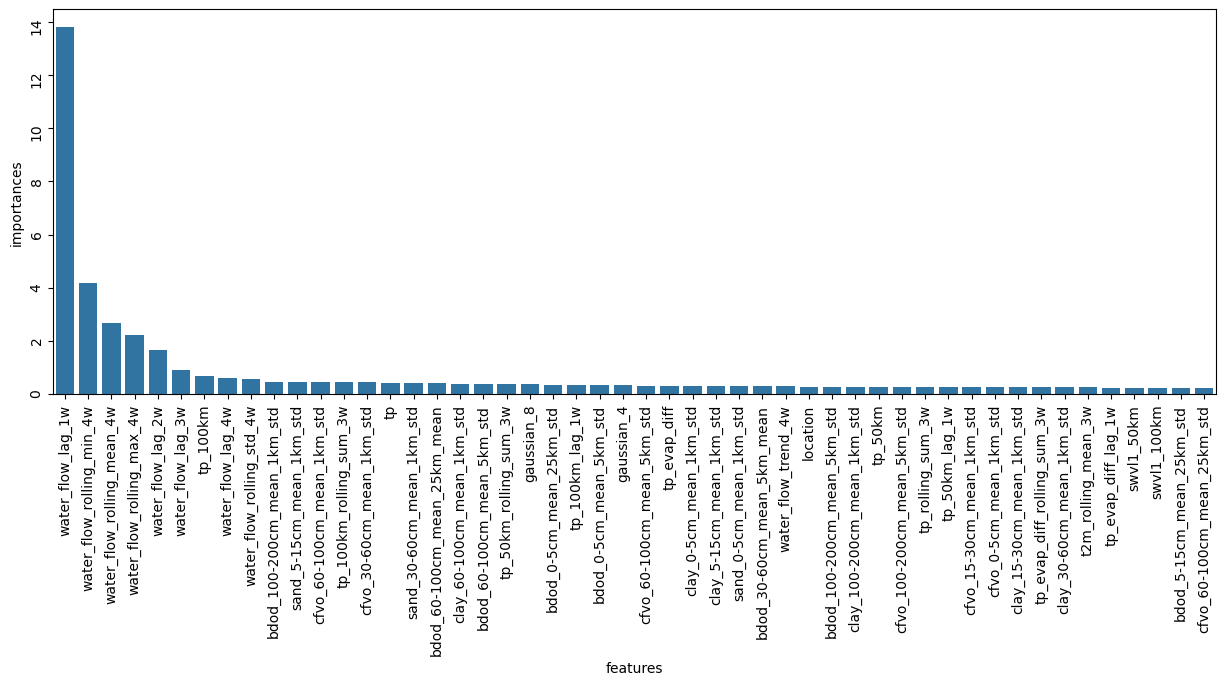

In [172]:
plt.figure(figsize = (15, 5))
sns.barplot(feat_importances.sort_values('importances', ascending = False).iloc[:50, :], x = 'features', y = 'importances')
plt.tick_params(rotation = 90)

In [173]:
np.mean(list(model.results.values()))

2.583385143805406

In [174]:
%%time
res, _ = model.predict(df_test)

CPU times: user 3.37 s, sys: 48.6 ms, total: 3.42 s
Wall time: 2.99 s


In [175]:
df_output = []
for key, value in res.items():
    temp = pd.DataFrame(value, columns = [f'week_{i}_{key}' for i in range(4)])
    df_output.append(temp)
df_output = pd.concat(df_output, axis = 1)
df_output = df_output.clip(0, np.inf)
df_output[df_output.filter(like = 'sup').columns] = df_output.filter(like = 'sup') + 0.01
df_output[df_output.filter(like = 'inf').columns] = df_output.filter(like = 'inf') - 0.01
for i in range(0, 4):
    df_output[[f'week_{i}_inf', f'week_{i}_pred', f'week_{i}_sup']] = np.sort(df_output[[f'week_{i}_inf', f'week_{i}_pred', f'week_{i}_sup']].values, axis = 1)
df_output[['station_code', 'ObsDate']] = df_test[['station_code', 'ObsDate']]
key = ['pred', 'inf', 'sup']
df_output = df_output[['station_code'] + [f'week_{i}_{key[j]}' for i in range(4) for j in range(3)] + ['ObsDate']]

In [176]:
df_test.shape

(1390, 221)

In [177]:
df_output.station_code.nunique()

54

In [178]:
df_output

,station_code,week_0_pred,week_0_inf,week_0_sup,week_1_pred,week_1_inf,week_1_sup,week_2_pred,week_2_inf,week_2_sup,week_3_pred,week_3_inf,week_3_sup,ObsDate
0,6119020,48.011141,22.077792,82.282367,42.184618,18.036145,69.776360,38.540872,12.623444,85.501691,33.525556,9.956976,60.089034,2004-02-01
1,6119020,21.517176,9.291695,34.176075,24.448719,8.606828,46.725560,25.293121,7.172691,45.602145,24.940270,5.166054,47.804668,2004-04-25
2,6119020,15.112368,9.216932,24.379599,13.062959,7.064036,23.011463,10.747191,4.006548,20.776948,11.248832,4.018457,26.729154,2004-07-18
3,6119020,5.934333,2.007303,16.650437,6.792232,2.348965,19.347352,9.986631,3.086674,32.648418,12.083504,2.590480,35.199082,2004-10-10
4,6119020,18.260036,9.789246,30.085885,19.537043,7.829370,41.154797,20.699837,6.235171,40.972378,20.010415,5.231347,41.499977,2005-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,56994500,1749.706823,626.039371,2734.706628,1994.833210,616.742649,3909.309926,1630.308487,497.351641,3267.784863,1478.630331,501.218054,3145.326038,2008-11-30
1386,56994500,1028.026316,719.096297,1492.596968,890.805196,667.886141,1243.422387,974.467647,529.927892,1819.506082,1026.560928,520.499611,2158.484059,2009-02-22
1387,56994500,710.001568,538.460236,972.147816,706.053005,506.511321,1057.759478,688.296605,428.374127,1175.532859,656.083604,441.155320,1303.584260,2009-05-17
1388,56994500,472.462191,375.426206,740.961133,428.441478,363.258834,496.249693,422.453202,342.199263,543.820127,415.842963,335.934735,490.532372,2009-08-09


In [179]:
X_ = X_train.reset_index(drop = True)

In [180]:
def compute_non_negative_log_likelihood(
    y_true,
    y_pred, 
    y_quantiles,
    station_codes,
    station_stats,
    alpha=.1
):
    """
    Custom log-likelihood scoring function.

    Parameters:
        y_pred : The predictions
        y_quantiles: Prediction Intervals
        y_true : True target values.
        cv_data : Full DataFrame that includes extra columns
        (e.g., "station_code").
        station_stats : Station-level statistics needed for standardization.
        alpha : Significance level (default from ALPHA).

    Returns:
        nll_s : Computed log-likelihood score.
    """
    # Standardize the values.
    y_true_std = standardize_values(
        y_true.to_numpy(),
        station_codes,
        station_stats)
    y_pred_std = standardize_values(
        y_pred,
        station_codes,
        station_stats)
    y_lower_std, y_upper_std = standardize_prediction_intervals(
        y_quantiles,
        station_codes,
        station_stats)

    # Compute sigma from the prediction interval.
    sigma_std = (y_upper_std - y_lower_std) / 3.29
    sigma_std = np.maximum(sigma_std, 1e-6)
    
    # Compute the negative log-likelihood.
    nll_s = (1 / len(y_true_std)) * np.sum(
        np.log(sigma_std) + np.abs(y_true_std - y_pred_std) / (2 * sigma_std)
    )

    # Optionally, print some diagnostics.
    cov = np.mean(
        (y_true_std >= y_lower_std) & (y_true_std <= y_upper_std))
    i_size = np.mean(y_upper_std - y_lower_std)
    print(
        f"Fold: coverage = {cov:.3f}, interval size = {i_size:.3f}")

    return nll_s

In [181]:
# n = 0
# y_true = y_train.iloc[:, n]
# y_pred = df_output.iloc[:, n]
# y_quantiles = df_output[[f'week_{n+1}_inf', f'week_{n+1}_sup']].values
# station_codes = X_train.station_code
# station_stats = get_station_stats(y_true, station_codes)

In [182]:
# np.abs(y_pred - y_true).mean()

In [183]:
# nll = compute_non_negative_log_likelihood(
#     y_true,
#     y_pred, 
#     y_quantiles,
#     station_codes,
#     station_stats,
#     alpha = 0.1
# )
# nll

In [184]:
# df.groupby('location').water_flow_week_1.quantile([0, 0.25, 0.5, 0.75, 1])

In [185]:
# df_test.groupby('location').station_code.nunique()

6119020


/tmp/ipykernel_478762/84587328.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp_X['ObsDate'] = pd.to_datetime(samp_X.ObsDate)
/tmp/ipykernel_478762/84587328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp_X_true['ObsDate'] = pd.to_datetime(samp_X_true.ObsDate)


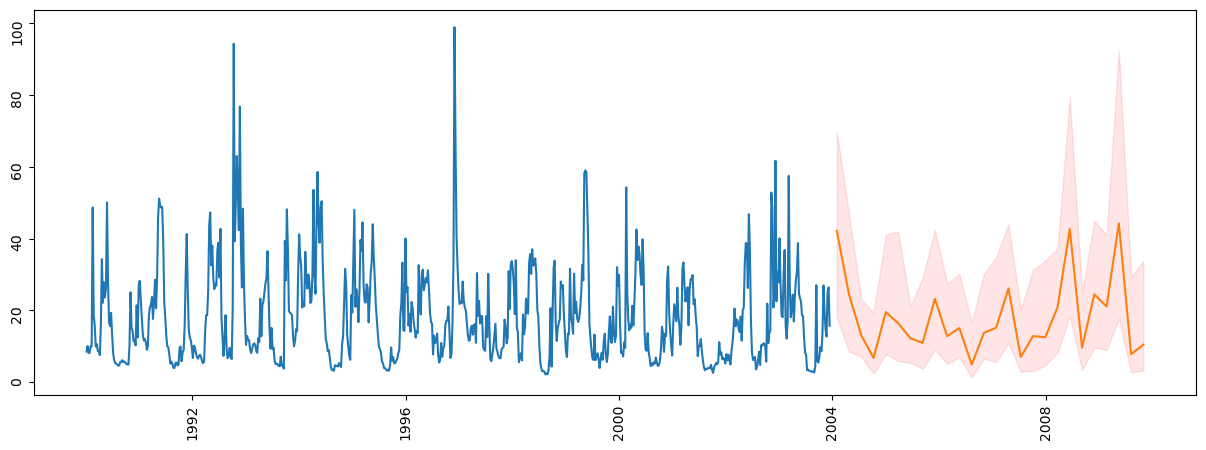

In [187]:
n = 0
j = 0
station_codes = df_test.station_code
plt.figure(figsize = (15, 5))
samp_X = df_test[df_test.station_code == station_codes.unique()[j]] #'56610000'] #
samp_X_true = X_train[X_train.station_code == station_codes.unique()[j]]
samp_X['ObsDate'] = pd.to_datetime(samp_X.ObsDate)
samp_X_true['ObsDate'] = pd.to_datetime(samp_X_true.ObsDate)
print(station_codes.unique()[j])
samp_y_true = y_train.loc[samp_X_true.index]
pred_y = df_output.loc[samp_X.index]
plt.plot(samp_X_true.ObsDate, samp_y_true.iloc[:, n].values);
plt.plot(samp_X.ObsDate, pred_y.loc[:, f'week_{n+1}_pred'])
plt.fill_between(samp_X.ObsDate, pred_y.loc[:, f'week_{n+1}_inf'], pred_y.loc[:, f'week_{n+1}_sup'], color = 'red', alpha = 0.1)
plt.tick_params(rotation = 90)

In [188]:
df_output.to_csv('predictions.csv', index = False)

In [157]:
f = 1
m = 0
feat_importances = pd.DataFrame({
    'features': gbt_model.models[f'fold_{f}_model_{m}'].models_[0].feature_names_,
    'importances': gbt_model.models[f'fold_{f}_model_{m}'].models_[0].feature_importances_
})

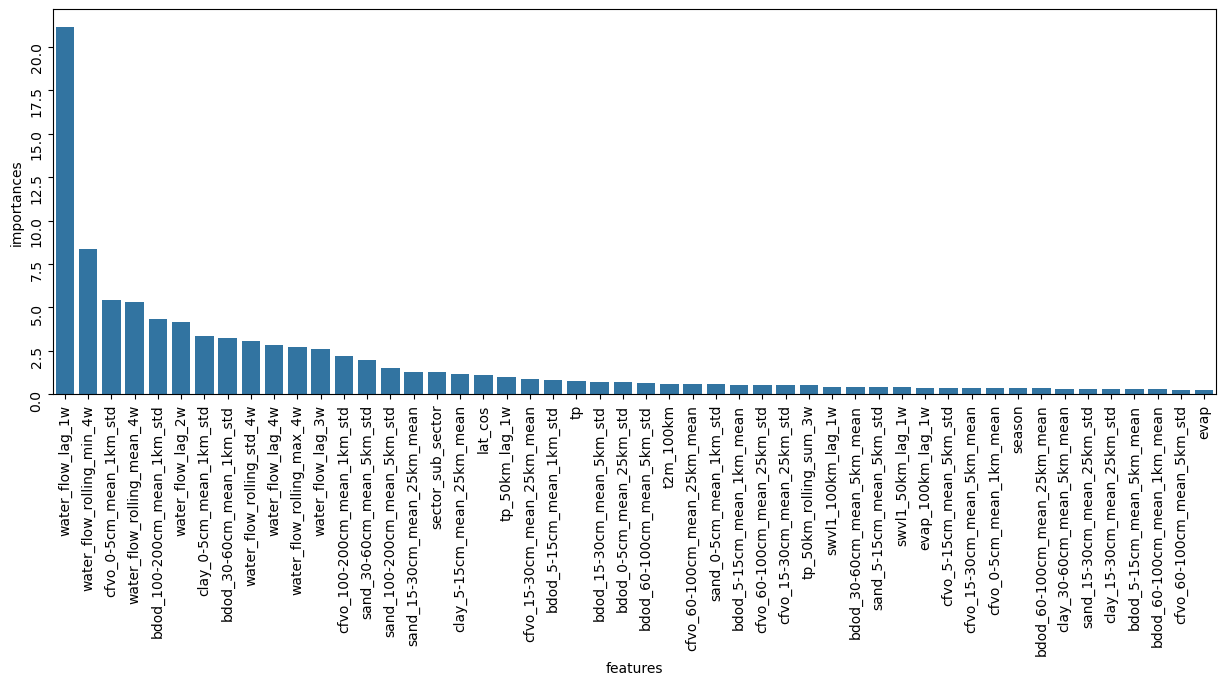

In [158]:
plt.figure(figsize = (15, 5))
sns.barplot(feat_importances.sort_values('importances', ascending = False).iloc[:50, :], x = 'features', y = 'importances')
plt.tick_params(rotation = 90)

In [159]:
# df_output.iloc[[1697,  4502,  5079, 10736, 11798, 16615, 18910, 19523, 21110, 23360]]#, y_train.loc[1697]

In [160]:
# y_train.iloc[[1697,  4502,  5079, 10736, 11798, 16615, 18910, 19523, 21110, 23360]]

In [ ]:
# predictions[f"week_{i}_pred"] = y_pred_test[i]
# predictions[f"week_{i}_sup"] = y_pred_test_quantile[i][:,1]
# predictions[f"week_{i}_inf"] = y_pred_test_quantile[i][:,0]

### Model 2 - Ensemble GBT

In [ ]:
df.groupby('station_code')['water_flow_week_1'].quantile([0, 0.05, 0.5, 0.95, 1]).head(27)

In [ ]:
y_train.iloc[:, 0].quantile([0.05, 0.5, 0.95])

In [ ]:
import catboost as cb

In [143]:
m = cb.CatBoostRegressor(loss_function = MultiHuberLoss(1), eval_metric = MultiMAEMetric(), od_wait = 100)

In [145]:
import inspect

In [146]:
inspect.getsource(m._is_multitarget_objective)

'    @staticmethod\n    def _is_multitarget_objective(loss_function):\n        return isinstance(loss_function, str) and is_multitarget_objective(loss_function)\n'

In [147]:
X_train.shape

(28392, 214)

In [156]:
m = cb.CatBoostRegressor(loss_function = MultiQuantileLoss(), eval_metric = MultiMAEMetric(), od_wait = 100, verbose = 10)
X_ = pd.DataFrame(np.random.uniform(-3.3, 3.3, (30000, 612)))
y = pd.DataFrame(np.random.uniform(0, 10, (30000, 5)))
X_v = pd.DataFrame(np.random.uniform(-3.3, 3.3, (5, 612)))
y_v = pd.DataFrame(np.random.uniform(0, 5000, (5, 5)))
m.fit(X_, y, eval_set = [(X_v, y_v)])

/home/dakinniyi/miniconda3/envs/zindi_geoai/lib/python3.12/site-packages/catboost/core.py:2321: UserWarning: Can't optimze method "calc_ders_multi" because self argument is used
  _check_train_params(params)


0:	learn: 14.2384173	test: 11826.4617335	best: 11826.4617335 (0)	total: 3.54s	remaining: 59m 2s
10:	learn: 42.1806629	test: 11808.5287339	best: 11783.8137345 (3)	total: 34s	remaining: 50m 57s
20:	learn: 67.3320691	test: 11740.9497355	best: 11740.9497355 (20)	total: 1m 4s	remaining: 50m 11s
30:	learn: 42.6586056	test: 11795.4477342	best: 11740.9497355 (20)	total: 1m 34s	remaining: 49m 25s


CatBoostError: catboost/python-package/catboost/helpers.cpp:57: Traceback (most recent call last):
  File "_catboost.pyx", line 1688, in _catboost._ObjectiveCalcDersMultiTarget
  File "/tmp/ipykernel_345748/1659242136.py", line 12, in calc_ders_multi
    def calc_ders_multi(self, approxes, target, weight):
    
KeyboardInterrupt


In [ ]:
y_train.max(), y_train.min()

### Model 3 - Direct Deep Learning

### Model 4 - Ensemble Deep Learning